In [3]:
import mne
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Path
raw = mne.io.read_raw_eeglab(
    "./data/sub-1001/eeg/sub-1001_task-VisualOddball_eeg.set",
    preload=True
)

raw.info

/var/folders/td/mm4gmgdx7ss6q3h414hzvrcm0000gn/T/ipykernel_68734/3704282881.py:7: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(


<Info | 8 non-empty values
 bads: []
 ch_names: FP1, Fz, F3, F7, FC3, C3, C5, TP9, CPz, Pz, P3, P7, PO3, PO7, ...
 chs: 32 EEG
 custom_ref_applied: False
 dig: 32 items (32 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 500.0 Hz
>

In [7]:
events_df = pd.read_csv(
    "./data/sub-1001/eeg/sub-1001_task-VisualOddball_events.tsv",
    sep="\t",
)
events_df = events_df[events_df["value"] != "boundary"]
events_df.head()

,onset,duration,sample,value
1,12.902,0.002,6451,202
2,19.350,0.002,9675,202
3,23.612,0.002,11806,45
4,23.982,0.002,11991,201
5,25.138,0.002,12569,41


In [8]:
events = np.column_stack((
    events_df["sample"].values,
    np.zeros(len(events_df), dtype=int),
    events_df["value"].astype(int).values
))

In [16]:
target_codes = ["11","22","33","44","55"]

nontarget_codes = [
    "12","13","14","15",
    "21","23","24","25",
    "31","32","34","35",
    "41","42","43","45",
    "51","52","53","54"
]

new_codes = []

for v in events_df["value"]:
    if v in target_codes:
        new_codes.append(1)
    elif v in nontarget_codes:
        new_codes.append(2)
    else:
        new_codes.append(0)
valid_stim_codes = target_codes + nontarget_codes
events_df = events_df[events_df["value"].isin(valid_stim_codes)]

events = np.column_stack((
    events_df["sample"].values,
    np.zeros(len(events_df), dtype=int),
    np.array(new_codes)
))

event_id = {"Target": 1, "NonTarget": 2}

In [17]:
raw.filter(0.1, 30, fir_design='firwin')
raw.set_eeg_reference('average')
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin=-0.2,
    tmax=0.8,
    baseline=(-0.2, 0),
    preload=True
)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 16501 samples (33.002 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Not setting metadata
210 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 210 events and 501 original time points ...
0 bad epochs dropped


In [18]:
evoked_target = epochs["Target"].average()
evoked_nontarget = epochs["NonTarget"].average()

/var/folders/td/mm4gmgdx7ss6q3h414hzvrcm0000gn/T/ipykernel_68734/1128079557.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(


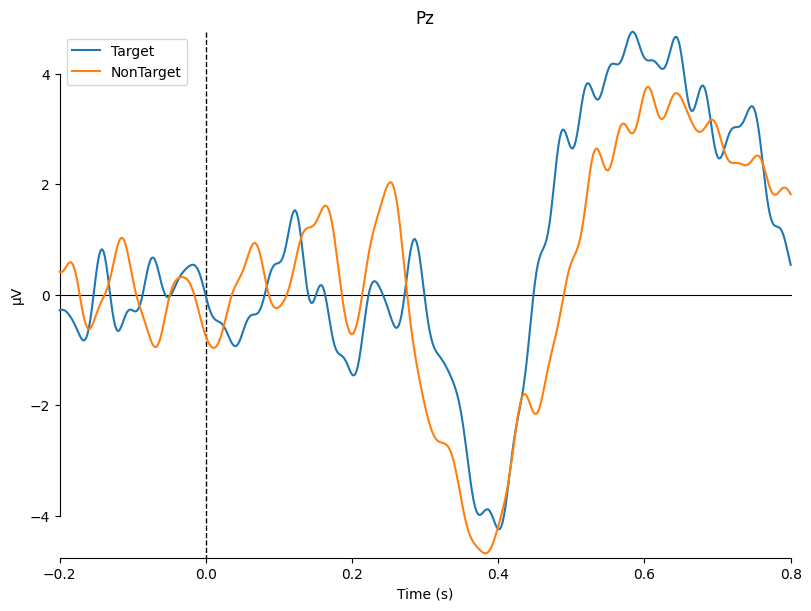

[<Figure size 800x600 with 1 Axes>]

In [19]:
mne.viz.plot_compare_evokeds(
    {"Target": evoked_target, "NonTarget": evoked_nontarget},
    picks="Pz"
)

In [ ]:
picks = mne.pick_channels(evoked_target.ch_names, ["Pz"])

p300_target = evoked_target.copy().crop(0.3, 0.6).data[picks].mean()
p300_nontarget = evoked_nontarget.copy().crop(0.3, 0.6).data[picks].mean()

print("Target mean P300:", p300_target)
print("NonTarget mean P300:", p300_nontarget)

4.758172701150718


In [22]:
evk = evoked_target.copy().crop(0.3, 0.6)
picks = mne.pick_channels(evk.ch_names, ["Pz"])

p300_peak_target = evk.data[picks].max()
print(p300_peak_target * 1e6)

4.758172701150718


In [25]:
epochs_target = epochs["Target"].copy().crop(0.3, 0.6)
epochs_nontarget = epochs["NonTarget"].copy().crop(0.3, 0.6)

data_t = epochs_target.get_data(picks="Pz").mean(axis=2).flatten()
data_nt = epochs_nontarget.get_data(picks="Pz").mean(axis=2).flatten()

In [26]:
from scipy.stats import ttest_ind

t, p = ttest_ind(data_t, data_nt)
print("p-value:", p)

p-value: 0.25653291279837787
